# Sparse + Low-Rank Splitting

Suppose we are given a data matrix $A$, and know that it has a form $$A=L+S,$$ where $L$ is of low-rank and $S$ is sparse, but we know neither the rank of $L$ nor the non-zero entries of $S$. 

_Can we recover $L$ and $S$?_

The answer is _YES, with high probability and with an efficient algorithm_. 

_Sparse + Low-rank_ splitting can be successfully applieed to video surveilance, face recognition, latent semantic indexing, and ranking and collaborative filtering. 

## Prerequisites

The reader should be familiar with linear algebra concepts, particularly SVD and its properties and algorithms.
 
## Competences 

The reader should be able to apply sparse + low-rank splitting to real problems.

## References

For more details see [E. J. Candes, X. Li, Y. Ma, and J. Wright, Robust Principal Component Analysis?][CLMW09]

__Credits__: The author wishes to thank Dimitar Ninevski, a former IAESTE intern, for collecting and preparing some of the material. 

[CLMW09]: http://arxiv.org/abs/0912.3599 "Emmanuel J. Candes, Xiaodong Li, Yi Ma, John Wright, 'Robust Principal Component Analysis?', arXiv:0912.3599, 2009."


## Definitions

Let $A\in\mathbb{R}^{m\times n}$ have rank $r$, and let $A=U\Sigma V^T$ be its SVD.

The __nuclear norm__ of $A$ is $\|A\|_*=\sum\limits_{i=1}^r \sigma_i(A)$.

Let $\|A\|_1=\sum\limits_{i,j} |A_{ij}|$ denote the $1$-norm of $A$ seen as a long vector.

Let $\|A\|_{\infty}=\max\limits_{i,j} |A_{ij}|$ denote the $\infty$-norm of $A$ seen as a long vector.

Given $\tau>0$, the __shrinkage operator__ $\mathcal{S}_{\displaystyle\tau}:\mathbb{R}\to \mathbb{R}$ is defined by
$\mathcal{S}_{\displaystyle\tau}(x)=\mathop{\mathrm{sign}}(x)\max\{|x|-\tau,0\}$,
and is extended to matrices by applying it to each element. 

Given $\tau>0$, the __singluar value thresholding operator__ is
$\mathcal{D}_{\displaystyle\tau}(A)=U \mathcal{S}_{\displaystyle\tau} (\Sigma) V^T$.


## Facts

Let $A=L+S$ be the splitting that we are looking for.

1. The problem can be formulated as 
$\mathop{\textrm{arg min}}\limits_{\displaystyle \mathop{\mathrm{rank}}(L)\leq k} \|A-L\|_2$.

2. The problem makes sense if the __incoherence conditions__ 
$$
\max_{\displaystyle i} \| U_{:,1:r}^T e_i\|_2^2\leq \frac{\mu r}{m}, \quad
\max_{\displaystyle i} \| V_{:,1:r}^T e_i\|_2^2\leq \frac{\mu r}{n}, \quad
\|UV^T\|_{\infty} \leq \sqrt{\frac{\mu r}{m\cdot n}},
$$
hold for some parameter $\mu$.

3. If the incoherence conditions are satisfied, the __Principal Component Pursuit estimate__,
$$
\mathop{\textrm{arg min}}\limits_{\displaystyle L+S=A} \|L\|_*+\lambda \|S\|_2,
$$
exactly recovers $L$ and $S$.

4. _Principal Component Pursuit by Alternating Directions_ algorithm finds the above estimate
    1. _Initialization_: $S=0$, $Y=0$, $L=0$, $\mu>0$, $\delta=10^{-7}$.
    2. _Iterations_: while $\|A-L-S\|_F>\delta\|A\|_F$ repeat
        1. _SV Thresholding_: $L=\mathcal{D}_{\displaystyle \mu^{-1}}(A-S-\mu^{-1}Y)$
        2. _Shrinkage_: $S=\mathcal{S}_{\displaystyle \lambda \mu^{-1}}(A-L+\mu^{-1}Y)$
        3. _Updating_: $Y=Y+\mu(A-L-S)$

### Example - Random matrices

In [1]:
# Shrinkage
function Shr(x::Array{T},τ::T) where T
    sign.(x).*max.(abs.(x).-τ,zero(T))
end

Shr (generic function with 1 method)

In [2]:
import Random
Random.seed!(421)
A=rand(3,5)

3×5 Array{Float64,2}:
 0.345443  0.973053  0.17008   0.135538  0.608612
 0.68487   0.105135  0.525208  0.958365  0.346561
 0.650991  0.77247   0.785847  0.560486  0.561248

In [3]:
Shr(A,0.5)

3×5 Array{Float64,2}:
 0.0       0.473053  0.0        0.0       0.108612 
 0.18487   0.0       0.0252085  0.458365  0.0      
 0.150991  0.27247   0.285847   0.060486  0.0612483

In [4]:
using LinearAlgebra

In [5]:
# Singular value thresholding
function D(A::Array{T},τ::T) where T
    # U,σ,V=svd(A)
    # This can be replaced by a faster approach
    V=svd(A)
    S=Shr(V.S,τ)
    k=count(!iszero,S)
    return (V.U[:,1:k]*Diagonal(S[1:k]))*V.Vt[1:k,:]
end

D (generic function with 1 method)

In [6]:
A

3×5 Array{Float64,2}:
 0.345443  0.973053  0.17008   0.135538  0.608612
 0.68487   0.105135  0.525208  0.958365  0.346561
 0.650991  0.77247   0.785847  0.560486  0.561248

In [7]:
svdvals(A)

3-element Array{Float64,1}:
 2.147058097489387 
 0.9288930517087124
 0.2699612637076009

In [8]:
C=D(A,0.5)

3×5 Array{Float64,2}:
 0.294585  0.600227  0.266091  0.176063  0.387429
 0.472944  0.221797  0.442502  0.579674  0.286861
 0.520133  0.582053  0.479679  0.502137  0.468237

In [9]:
svdvals(C)

3-element Array{Float64,1}:
 1.6470580974893876   
 0.42889305170871206  
 9.987190497736368e-17

In [10]:
function PCPAD(A::Array{T}) where T
    # Initialize
    δ=1.0e-7
    tol=δ*norm(A)
    m,n=size(A)
    S=zero(A)
    Y=zero(A)
    L=zero(A)
    T₁=zero(A)
    μ=(m*n)/(4*(norm(A[:],1)))
    μ₁=one(T)/μ
    λ=one(T)/sqrt(max(map(T,m),n))
    λμ₁=λ*μ₁
    ν=1e20
    maxiter=200
    iterations=0
    # Iterate
    while (ν>tol) && iterations<maxiter
        # println(iterations," ",ν)
        iterations+=1
        L.=D(A-S+μ₁.*Y,μ₁)
        S.=Shr(A-L+μ₁.*Y,λμ₁)
        T₁.=(A-L-S)
        Y.+=(μ.*T₁)
        ν=norm(T₁)
    end
    L,S, iterations
end

PCPAD (generic function with 1 method)

In [11]:
@time L,S,iter=PCPAD(A)

  0.389696 seconds (1.55 M allocations: 72.590 MiB, 4.59% gc time)


([0.233681 0.19195 … 0.135538 0.246954; 0.460765 0.108967 … 0.469864 0.346561; 0.650991 0.291443 … 0.560486 0.561248], [0.111762 0.781103 … -0.0 0.361658; 0.224105 -0.00383257 … 0.488501 -0.0; 0.0 0.481027 … 0.0 0.0], 148)

In [12]:
rank(L),norm(A-L-S)

(2, 2.2062144355986492e-7)

In [13]:
L

3×5 Array{Float64,2}:
 0.233681  0.19195   0.17008   0.135538  0.246954
 0.460765  0.108967  0.525208  0.469864  0.346561
 0.650991  0.291443  0.64519   0.560486  0.561248

In [14]:
S

3×5 Array{Float64,2}:
 0.111762   0.781103    -0.0       -0.0        0.361658
 0.224105  -0.00383257   0.0        0.488501  -0.0     
 0.0        0.481027     0.140657   0.0        0.0     

In [15]:
# Now the real test
# Dimensions of the matrix
m=100
n=100
# Rank of the low-rank part L
k=10
# Generate L
L=rand(m,k)*rand(k,n)
rank(L)

10

In [16]:
using SparseArrays

In [17]:
# Sparsity of the sparse part S
sparsity=0.1
# Generate S
S=10*sprand(m,n,sparsity)
nnz(S)

1006

In [18]:
# Generate the matrix A, it is a full matrix with full rank
A=L+S
rank(A)

100

In [20]:
# Decompose A into L₁ and S₁
@time L₁,S₁,iters=PCPAD(A);

  0.426594 seconds (5.04 k allocations: 166.834 MiB, 1.14% gc time)


In [21]:
iters, rank(L₁), norm(L), norm(L-L₁), norm(S), norm(S-S₁)

(132, 10, 253.97328079239296, 3.7800817202459454e-5, 181.41757653755946, 2.230745684081783e-5)

Although there might be no convergence, the splitting is still good. 

In [24]:
S₁

100×100 Array{Float64,2}:
  0.0   0.0          0.0      …   2.62652    0.0       -0.0       
 -0.0   0.0         -0.0          1.83969    0.0       -0.0       
 -0.0   0.0          2.13844     -0.0       -0.0        4.42683e-7
  0.0   0.0         -0.0          0.877967   0.0        0.0       
  0.0  -0.0         -0.0          0.0        7.20853    0.0       
 -0.0   0.0          0.0      …   1.01969   -0.0       -0.0       
 -0.0   5.94334e-7   8.59015     -0.0        0.0        0.0       
 -0.0   4.45529      0.0          0.0       -0.0        0.0       
  0.0   0.0          0.0         -0.0        0.0       -0.0       
 -0.0   0.0         -0.0          0.0        0.0        0.0       
  0.0   0.0          0.0      …  -0.0       -0.0       -0.0       
 -0.0   0.0          0.0         -0.0        0.0        7.9206    
  0.0  -0.0         -0.0          0.0       -0.0       -0.0       
  ⋮                           ⋱                                   
  0.0  -9.95267e-7   0.0          0.

In [25]:
Matrix(S)

100×100 Array{Float64,2}:
 0.0  0.0      0.0      0.0      0.0      0.0  …  2.62652   0.0       0.0    
 0.0  0.0      0.0      0.0      0.0      0.0     1.83969   0.0       0.0    
 0.0  0.0      2.13844  0.0      0.0      0.0     0.0       0.0       0.0    
 0.0  0.0      0.0      0.0      0.0      0.0     0.877966  0.0       0.0    
 0.0  0.0      0.0      0.0      0.0      0.0     0.0       7.20853   0.0    
 0.0  0.0      0.0      0.0      0.0      0.0  …  1.01969   0.0       0.0    
 0.0  0.0      8.59015  0.0      0.0      0.0     0.0       0.0       0.0    
 0.0  4.45529  0.0      0.0      0.0      0.0     0.0       0.0       0.0    
 0.0  0.0      0.0      0.0      0.0      0.0     0.0       0.0       0.0    
 0.0  0.0      0.0      6.83133  0.0      0.0     0.0       0.0       0.0    
 0.0  0.0      0.0      0.0      0.0      0.0  …  0.0       0.0       0.0    
 0.0  0.0      0.0      7.54778  1.36709  0.0     0.0       0.0       7.9206 
 0.0  0.0      0.0      0.0      0.0  

### Example - Face recognition

We will try to recover missing features. The images are chosen from the 
[Yale Face Database](http://vision.ucsd.edu/content/yale-face-database).


In [26]:
using Images

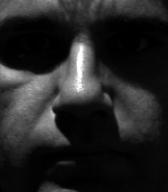

In [27]:
# First a single image
img=load("files/17.jpg")

In [28]:
show(img[1,1])

Gray{N0f8}(0.325)

In [29]:
A=map(Float64,img)

192×168 Array{Float64,2}:
 0.32549     0.305882    0.290196   …  0.0470588  0.0431373  0.0392157
 0.301961    0.294118    0.290196      0.0470588  0.0431373  0.0392157
 0.286275    0.294118    0.309804      0.0470588  0.0431373  0.0392157
 0.290196    0.313725    0.341176      0.0470588  0.0431373  0.0431373
 0.301961    0.32549     0.352941      0.054902   0.0470588  0.0431373
 0.309804    0.32549     0.341176   …  0.0627451  0.0509804  0.0470588
 0.321569    0.32549     0.32549       0.0745098  0.0588235  0.0470588
 0.337255    0.329412    0.321569      0.0784314  0.0588235  0.0470588
 0.329412    0.32549     0.313725      0.0980392  0.0705882  0.0509804
 0.32549     0.329412    0.333333      0.109804   0.0862745  0.0705882
 0.317647    0.337255    0.352941   …  0.117647   0.101961   0.0941176
 0.32549     0.352941    0.376471      0.117647   0.105882   0.0980392
 0.352941    0.380392    0.4           0.113725   0.101961   0.0901961
 ⋮                                  ⋱  ⋮           

In [30]:
# Compute the splitting and show number of iterations
@time L,S,iters=PCPAD(A)
iters, rank(L), norm(A), norm(A-L-S)

  0.994848 seconds (8.22 k allocations: 828.164 MiB, 3.02% gc time)


(200, 78, 40.54262512632593, 0.004239753054553014)

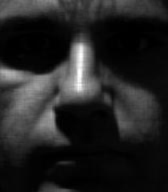

In [31]:
colorview(Gray,L)

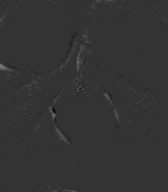

In [32]:
# Try S+0.5
colorview(Gray,S.+0.2)  

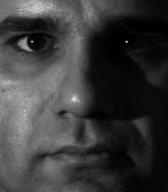

In [33]:
# Another image
img=load("files/19.jpg")

In [34]:
A=map(Float64,img)
L,S,iters=PCPAD(A)
iters, rank(L), norm(A), norm(A-L-S)

(200, 79, 53.08353496111299, 0.006883332844262282)

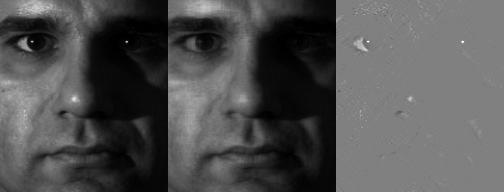

In [35]:
hcat(img,colorview(Gray,L),colorview(Gray,S.+0.5))

### Example - Multiple images

Each image of $168 \times 192$ pixels is converted to a vector of length 32256. 
All vectors are stacked in the columns of matrix $A$, and the low-rank + sparse splitting 
of $A$ is computed.

In [36]:
# Load all images in the collection
dir="./files/yaleB08/"
files=readdir(dir)

64-element Array{String,1}:
 ".directory"              
 "yaleB08_P00A+000E+00.pgm"
 "yaleB08_P00A+000E+20.pgm"
 "yaleB08_P00A+000E+45.pgm"
 "yaleB08_P00A+000E-20.pgm"
 "yaleB08_P00A+000E-35.pgm"
 "yaleB08_P00A+005E+10.pgm"
 "yaleB08_P00A+005E-10.pgm"
 "yaleB08_P00A+010E+00.pgm"
 "yaleB08_P00A+010E-20.pgm"
 "yaleB08_P00A+015E+20.pgm"
 "yaleB08_P00A+020E+10.pgm"
 "yaleB08_P00A+020E-10.pgm"
 ⋮                         
 "yaleB08_P00A-070E+00.pgm"
 "yaleB08_P00A-070E+45.pgm"
 "yaleB08_P00A-070E-35.pgm"
 "yaleB08_P00A-085E+20.pgm"
 "yaleB08_P00A-085E-20.pgm"
 "yaleB08_P00A-095E+00.pgm"
 "yaleB08_P00A-110E+15.pgm"
 "yaleB08_P00A-110E+40.pgm"
 "yaleB08_P00A-110E+65.pgm"
 "yaleB08_P00A-110E-20.pgm"
 "yaleB08_P00A-120E+00.pgm"
 "yaleB08_P00A-130E+20.pgm"

In [37]:
# import Pkg; Pkg.add("Netpbm")

In [39]:
n=length(files)-1
images=Array{Any}(undef,n)
B=Array{Any}(undef,n)
for i=1:n
    images[i]=load(joinpath(dir,files[i+1]))
    B[i]=map(Float64,images[i])
end

In [40]:
# See the images - last 9 images are meaningless
# for i=1:n; display(img[i]); end

In [41]:
# Form the big matrix - each image is converted to a column vector
mi,ni=size(images[1])
A=Array{Float64}(undef,mi*ni,n-9)
for i=1:n-9
    A[:,i]=vec(B[i])
end
size(A)

(32256, 54)

In [42]:
# Now the big SVDs - 1 minute
@time L,S,iters=PCPAD(A)
iters, rank(L), norm(A), norm(A-L-S)

 20.825583 seconds (8.04 k allocations: 34.098 GiB, 35.81% gc time)


(200, 27, 419.0677046909673, 0.005202750277099834)

In [43]:
reshape(S[:,1],mi,ni)

192×168 Array{Float64,2}:
 -0.00495669    0.0           0.0          …   0.0038532     0.000100633
 -0.00674239    0.0          -0.00115572       0.00252207    0.00518379 
 -0.00419446    0.0          -0.00442436       0.0018296     0.00586078 
  0.00120403   -0.0025382    -0.00135281      -0.00239806    0.003269   
 -0.0          -0.0           0.000585718     -0.00671884   -0.00840207 
  0.00363616    9.67909e-5   -0.00240804   …   0.0150508     0.00486174 
  0.000295163  -0.00246132    0.0048211        0.00467998    0.00391104 
 -0.00299876   -0.000282387   0.00251491       0.00134999    0.00466737 
  0.00317675    0.00294359    0.00415725       0.0100172     0.00455386 
  0.0059954    -0.000949929   0.0              0.0123673     0.0108048  
 -0.00121714   -0.00352895    0.000452436  …   0.00236832    0.00195632 
 -0.00300623   -0.00516701    0.00204093      -0.00736337   -0.000781504
  0.00572153    0.0123604     0.00470371       0.000977364  -0.00835812 
  ⋮                      

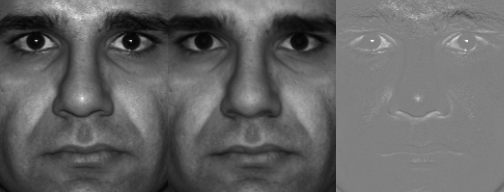

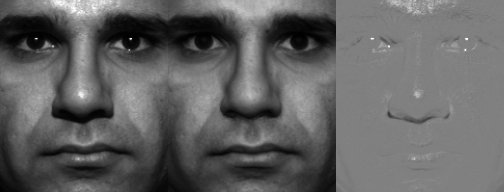

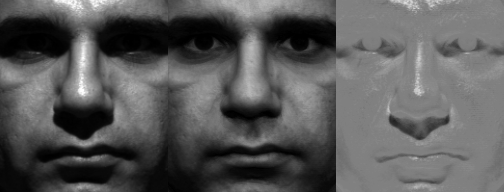

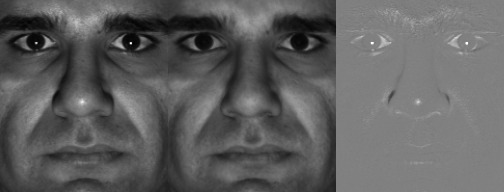

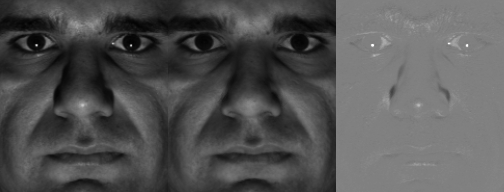

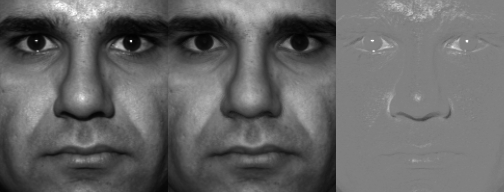

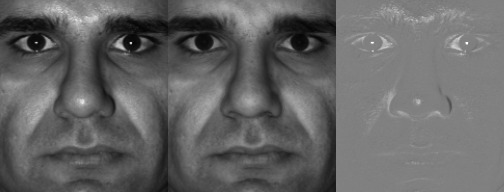

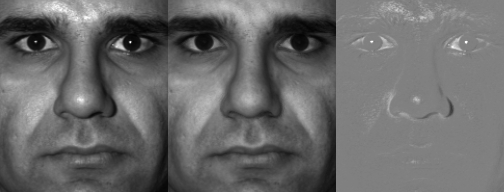

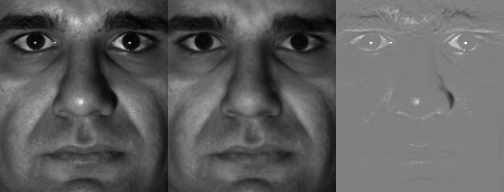

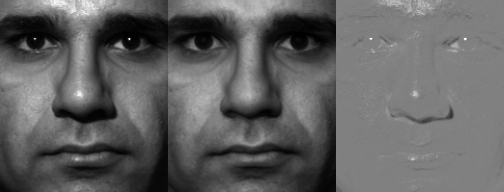

In [44]:
for i=1:10 # n-9
    Li=reshape(L[:,i],mi,ni)
    Si=reshape(S[:,i],mi,ni).+0.5
    display(hcat(images[i],colorview(Gray,Li),colorview(Gray,Si))) 
end

### Example - Mona Lisa's smile

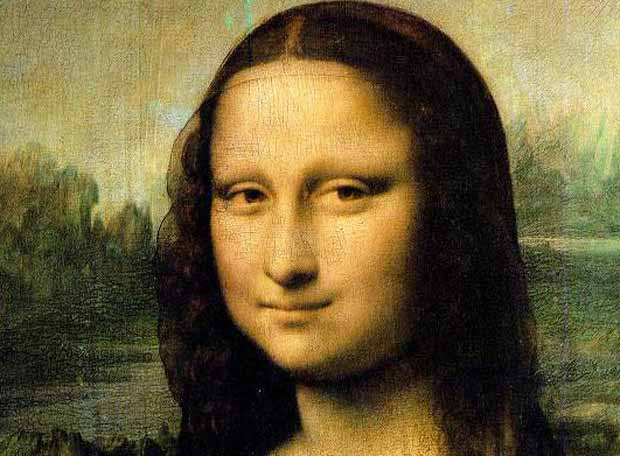

In [45]:
img=load("files/mona-lisa_1.jpg")

In [46]:
# Prema bilježnici S03
imgsep=float(channelview(img))

3×456×620 Array{Float32,3}:
[:, :, 1] =
 0.396078  0.505882  0.603922  0.603922  …  0.203922   0.290196  0.258824
 0.419608  0.529412  0.627451  0.615686     0.227451   0.313726  0.286275
 0.239216  0.34902   0.447059  0.439216     0.0862745  0.164706  0.12549 

[:, :, 2] =
 0.411765  0.482353  0.54902   0.545098  …  0.247059  0.329412  0.309804
 0.435294  0.505882  0.572549  0.556863     0.270588  0.356863  0.337255
 0.254902  0.32549   0.392157  0.380392     0.129412  0.196078  0.172549

[:, :, 3] =
 0.498039  0.509804  0.517647  0.490196  …  0.282353  0.337255  0.32549 
 0.521569  0.533333  0.529412  0.501961     0.305882  0.364706  0.352941
 0.341176  0.352941  0.352941  0.32549      0.156863  0.2       0.188235

...

[:, :, 618] =
 0.811765  0.764706  0.788235  0.870588  …  0.239216  0.294118  0.333333
 0.764706  0.717647  0.741176  0.823529     0.219608  0.266667  0.305882
 0.568627  0.521569  0.545098  0.627451     0.105882  0.156863  0.196078

[:, :, 619] =
 0.745098  0.807843 

In [47]:
size(imgsep)

(3, 456, 620)

In [48]:
# 1-2 minutes
# Red
@time RL,RS,Riter=PCPAD(imgsep[1,:,:])
# Green
GL,GS,Giter=PCPAD(imgsep[2,:,:])
# Blue
BL,BS,Biter=PCPAD(imgsep[1,:,:])

 10.464463 seconds (4.43 M allocations: 3.646 GiB, 2.59% gc time)


(Float32[0.468062 0.498654 … 0.776629 0.779655; 0.505889 0.500805 … 0.807842 0.831851; … ; 0.236331 0.271821 … 0.278431 0.306364; 0.219414 0.255513 … 0.290063 0.31577], Float32[-0.0719831 -0.0868896 … -0.0315309 -0.0463214; 0.0 -0.0184516 … -0.0 0.019129; … ; 0.053865 0.0575905 … -0.0 0.0191267; 0.0394097 0.0542905 … 0.0824862 0.154818], 200)

In [49]:
Giter, rank(GL), norm(imgsep[2,:,:]), norm(imgsep[2,:,:]-GL-GS)

(200, 242, 242.3543f0, 0.0012425436f0)

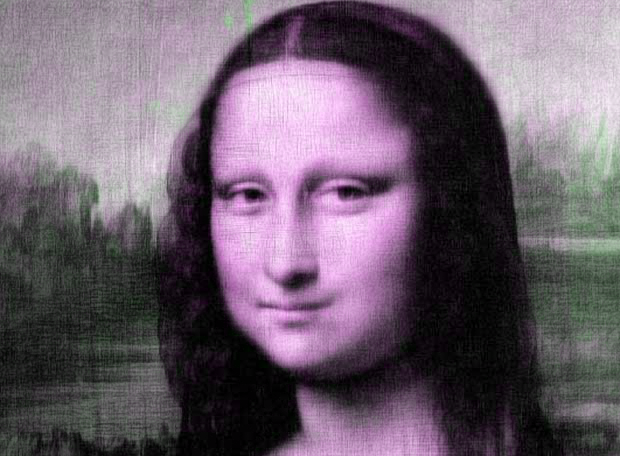

In [50]:
# Mona Lisa's low-rank component
colorview(RGB,RL,GL,BL)

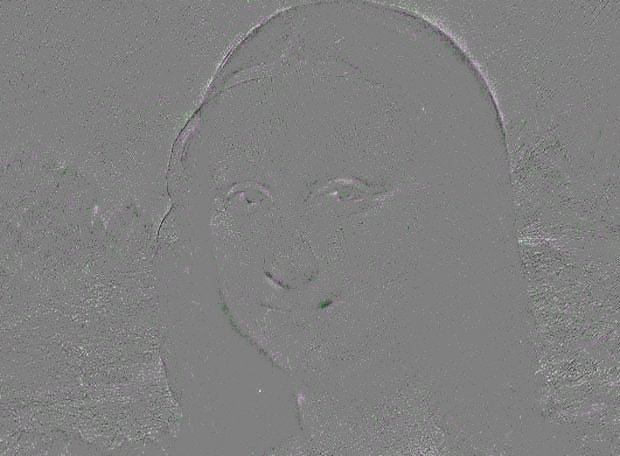

In [51]:
# Mona Lisa's sparse component
colorview(RGB,RS.+0.5,GS.+0.5,BS.+0.5)

### Example - Mona Lisa's hands

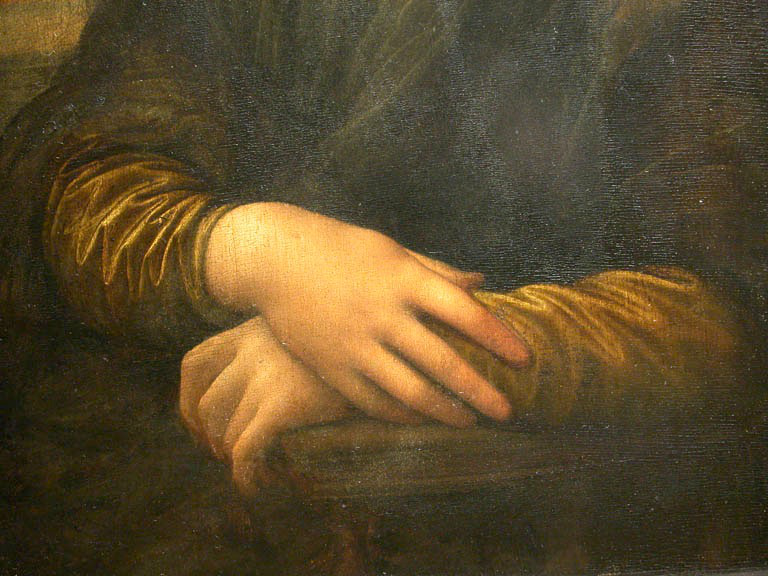

In [52]:
img=load("files/Mona_Lisa_detail_hands.jpg")

In [53]:
imgsep=float(channelview(img))
@time RL,RS,Riter=PCPAD(imgsep[1,:,:])
GL,GS,Giter=PCPAD(imgsep[2,:,:])
BL,BS,Biter=PCPAD(imgsep[1,:,:])
Giter, rank(GL), norm(imgsep[2,:,:]), 
norm(imgsep[2,:,:]-GL-GS)

 15.709275 seconds (8.42 k allocations: 5.402 GiB, 2.20% gc time)


(200, 306, 215.53857f0, 0.00048261715f0)

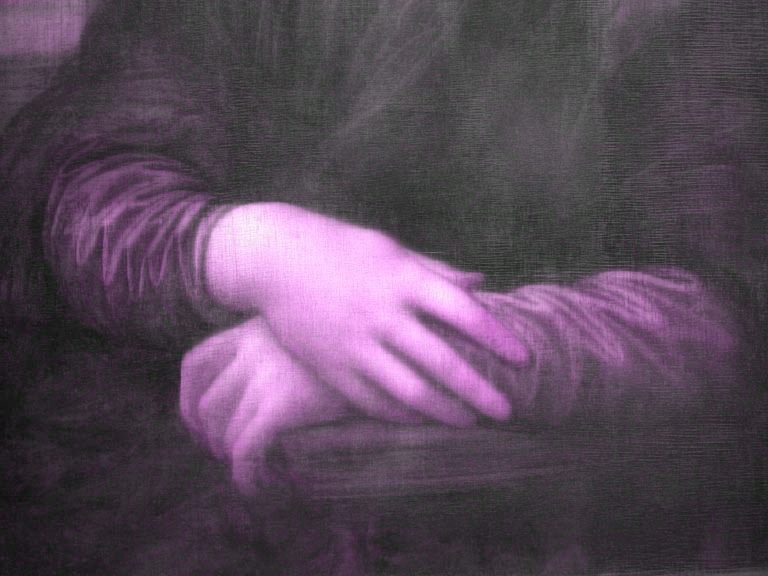

In [54]:
colorview(RGB,RL,GL,BL)

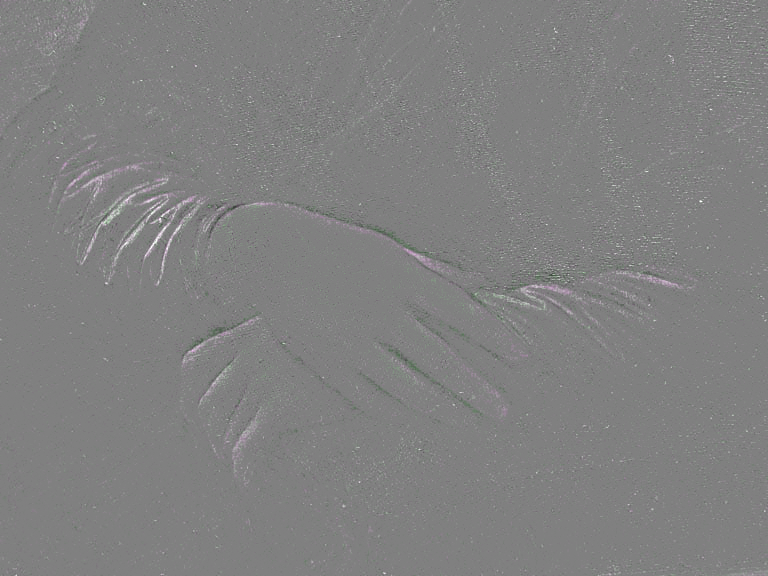

In [55]:
colorview(RGB,RS.+0.5,GS.+0.5,BS.+0.5)